In [70]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Bing
import requests
import folium
from wordcloud import WordCloud, STOPWORDS

cottecting to mongoDB:

In [52]:
client = MongoClient("mongodb://localhost:27017/")
db = client["project1"]
restaurants_collection = db["Restaurants"]
people_collection = db["people"]

In [53]:
restaurants_data = pd.DataFrame(list(restaurants_collection.find()))
print(restaurants_data.head())

                        _id                                  Name  \
0  647f54bcc655ace9e972b199                     Coach House Diner   
1  647f54bcc655ace9e972b19a                      Table Talk Diner   
2  647f54bcc655ace9e972b19c                          The Clam Bar   
3  647f54bcc655ace9e972b19d                           E Tutto Qua   
4  647f54bcc655ace9e972b19e  Black Angus Steakhouse - Federal Way   

        Street Address                      Location  \
0        55 State Rt 4     Hackensack, NJ 07601-6337   
1  2531 South Rd Ste C   Poughkeepsie, NY 12601-5476   
2    3914 Brewerton Rd            Syracuse, NY 13212   
3     270 Columbus Ave  San Francisco, CA 94133-4518   
4      2400 S 320th St    Federal Way, WA 98003-5465   

                                    Type   Reviews No of Reviews  \
0                               new type  4.005882          85.0   
1   American, Diner, Vegetarian Friendly       4.0         256.0   
2                 American, Bar, Seafood    

In [54]:
restaurants_data['state'] = restaurants_data['Location'].str.split(',').str[-1].str.strip().str[:2]
restaurants_data['city'] = restaurants_data['Location'].str.split(',').str[0]

In [55]:
print(restaurants_data.dtypes)
print(restaurants_data.head())

_id               object
Name              object
Street Address    object
Location          object
Type              object
Reviews           object
No of Reviews     object
Comments          object
Contact Number    object
Contact_Number    object
coordinates       object
state             object
city              object
dtype: object
                        _id                                  Name  \
0  647f54bcc655ace9e972b199                     Coach House Diner   
1  647f54bcc655ace9e972b19a                      Table Talk Diner   
2  647f54bcc655ace9e972b19c                          The Clam Bar   
3  647f54bcc655ace9e972b19d                           E Tutto Qua   
4  647f54bcc655ace9e972b19e  Black Angus Steakhouse - Federal Way   

        Street Address                      Location  \
0        55 State Rt 4     Hackensack, NJ 07601-6337   
1  2531 South Rd Ste C   Poughkeepsie, NY 12601-5476   
2    3914 Brewerton Rd            Syracuse, NY 13212   
3     270 Columbus Ave

In [56]:
restaurants_data['Reviews'] = pd.to_numeric(restaurants_data['Reviews'], errors='coerce')
restaurants_data['No of Reviews'] = pd.to_numeric(restaurants_data['No of Reviews'], errors='coerce')

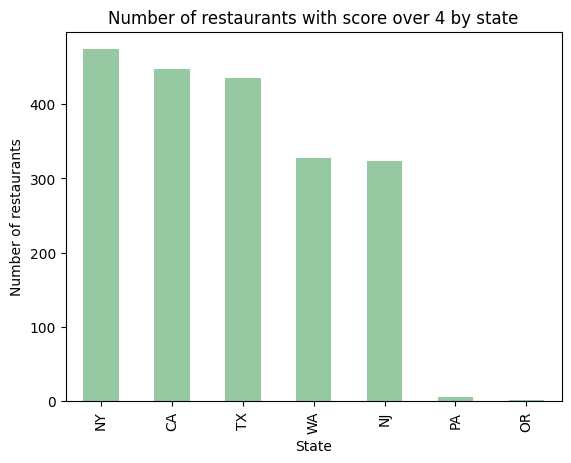

In [57]:
filtered_df = restaurants_data[restaurants_data['Reviews'] > 4]
state_counts = filtered_df['state'].value_counts()
state_counts.plot(kind='bar', color = '#96C8A2')
plt.title('Number of restaurants with score over 4 by state')
plt.xlabel('State')
plt.ylabel('Number of restaurants')
plt.show()

In [58]:
people_data = pd.DataFrame(list(people_collection.find()))
print(people_data.head())

                        _id                name  \
0  647f54dfd4c134fa260f3960           Tom Hanks   
1  647f54dfd4c134fa260f3961          Will Smith   
2  647f54dfd4c134fa260f3962   Leonardo DiCaprio   
3  647f54dfd4c134fa260f3963           Brad Pitt   
4  647f54dfd4c134fa260f3964  Scarlett Johansson   

                                  restaurant_visited  
0  [{'restaurant': 'Coach House Diner', 'score': ...  
1  [{'restaurant': 'John Thomas Steakhouse', 'sco...  
2  [{'restaurant': 'Revolve True Food & Wine Bar'...  
3        [{'restaurant': 'Social 37', 'score': 4.0}]  
4  [{'restaurant': 'Magic Castle', 'score': 5.0},...  


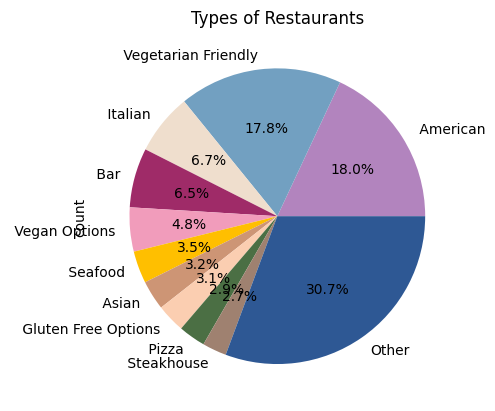

In [59]:
types = restaurants_data['Type'].str.split(',').explode()
type_counts = types.value_counts()
top_10_types = type_counts.head(10)
other_types_count = type_counts[10:].sum()
top_10_types['Other'] = other_types_count

colors = ['#B284BE', '#72A0C1', '#EFDECD', '#9F2B68', '#F19CBB', '#FFBF00', '#CD9575', '#FBCEB1', '#4B6F44', '#9F8170', '#2E5894', '#54626F', '#E97451', '#A3C1AD', '#FFFF99']
top_10_types.plot(kind='pie', autopct='%1.1f%%', colors=colors)
plt.title('Types of Restaurants')
plt.show()


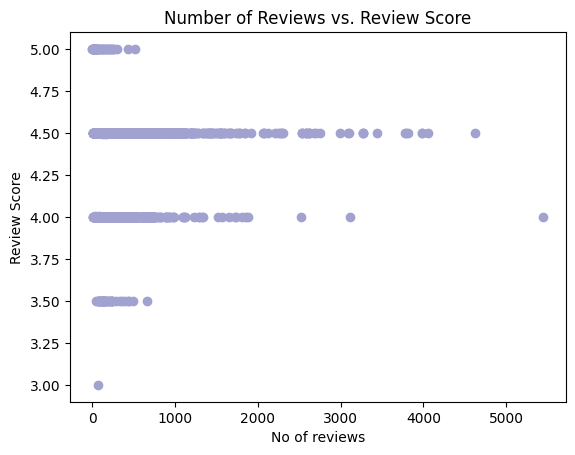

In [60]:
plt.scatter(restaurants_data['No of Reviews'], restaurants_data['Reviews'], color = '#A2A2D0')
plt.title('Number of Reviews vs. Review Score')
plt.xlabel('No of reviews')
plt.ylabel('Review Score')
plt.show()

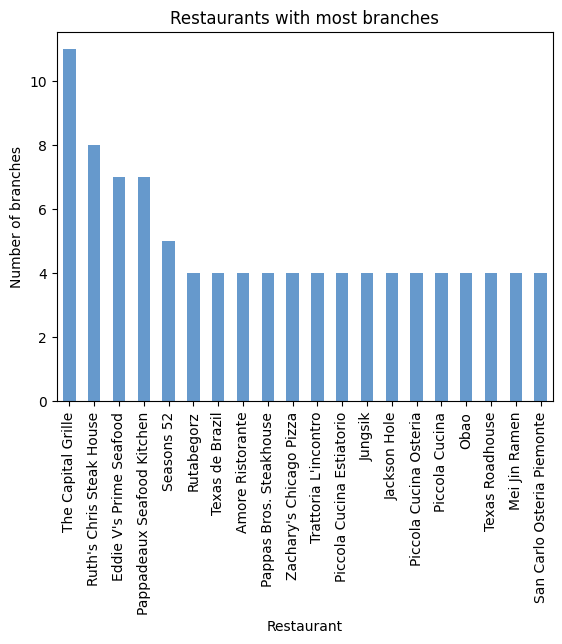

In [61]:
state_counts = filtered_df['Name'].value_counts().head(20)
state_counts.plot(kind='bar', color="#6699CC")
plt.title('Restaurants with most branches')
plt.xlabel('Restaurant')
plt.ylabel('Number of branches')
plt.show()

WordCloud for restaurants that have score gt 4

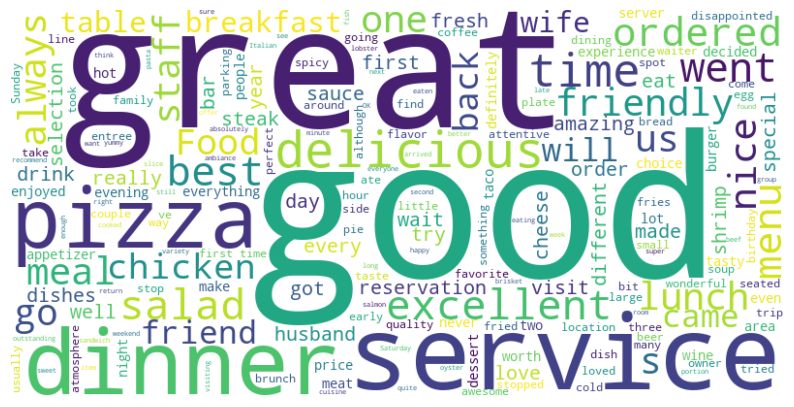

In [62]:
word_data = restaurants_data[restaurants_data['Reviews'] > 4].copy()
comments_not_null = word_data['Comments'].dropna()
comments_text = ' '.join([word for word in comments_not_null if not any(stopword in word for stopword in ['food', 'restaurant', 'place'])])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

WordCloud for restaurants that have score lt 4

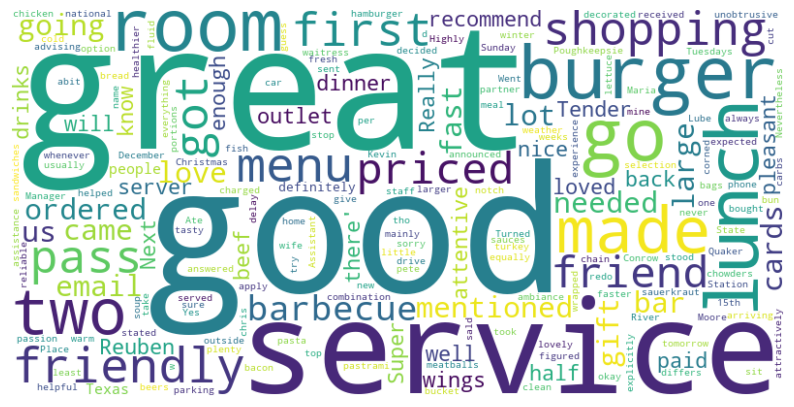

In [63]:
word_data = restaurants_data[restaurants_data['Reviews'] < 4].copy()
comments_not_null = word_data['Comments'].dropna()
comments_text = ' '.join([word for word in comments_not_null if not any(stopword in word for stopword in ['food', 'restaurant', 'place'])])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [64]:
from geopy.exc import GeocoderTimedOut

data = restaurants_data[restaurants_data['Reviews'] == 5].copy()

geolocator = Bing(api_key='AhpwrCFQAHjj_6XelmahpGUxECXe1tonsrdoV2zAc9VJETqAj-6ekcmoMaKv5Ri6')

def geocode_with_timeout(location):
    try:
        return geolocator.geocode(location)
    except GeocoderTimedOut:
        return None

data.loc[:, 'address'] = data['Street Address'] + ", " + data['Location']
data.loc[:, 'new_location'] = data['address'].apply(geocode_with_timeout)
data.loc[:, 'Latitude'] = data['new_location'].apply(lambda x: x.latitude if x is not None else np.nan)
data.loc[:, 'Longitude'] = data['new_location'].apply(lambda x: x.longitude if x is not None else np.nan)

print(data.head())



                          _id                  Name         Street Address  \
28   647f54bcc655ace9e972b1b6            Tabernilla  7124 Bob Bullock Loop   
134  647f54bcc655ace9e972b220            Ambrogio15       926 Turquoise St   
265  647f54bcc655ace9e972b2a3            Very Juice           422 Avenue P   
275  647f54bcc655ace9e972b2ad  HiroNori Craft Ramen      2222 Michelson Dr   
279  647f54bcc655ace9e972b2b1        Bean's & Lager          3301 36th Ave   

                            Location                                   Type  \
28             Laredo, TX 78041-2080       Spanish, Mediterranean, Wine Bar   
134         San Diego, CA 92109-1186               Italian, Pizza, Wine Bar   
265          Brooklyn, NY 11223-1935                                          
275            Irvine, CA 92612-1332   Japanese, Asian, Vegetarian Friendly   
279  Long Island City, NY 11106-1941              American, Steakhouse, Bar   

     Reviews  No of Reviews  \
28       5.0           39

### Restaurants with score 5 on the USA map:
Only score 5 because it was taking too long to find coordinates for all restaurants.

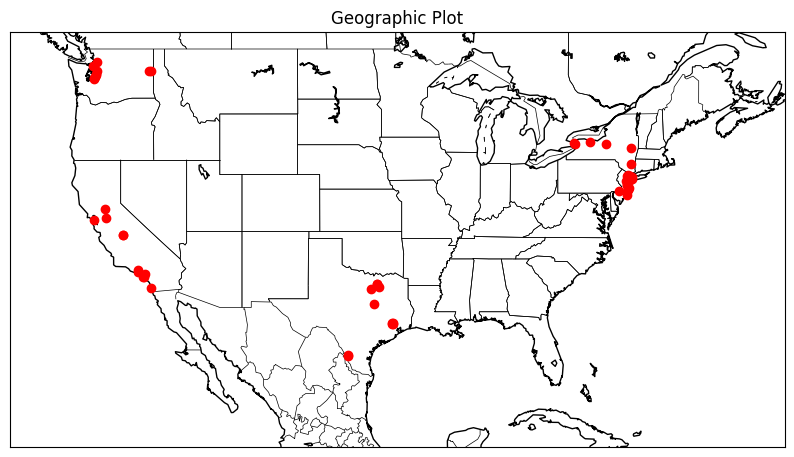

In [65]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

map = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='l')

map.drawcoastlines()
map.drawcountries()
map.drawstates()

x, y = map(data['Longitude'].astype(float), data['Latitude'].astype(float))
map.scatter(x, y, marker='o', color='red', zorder=5)
plt.title('Geographic Plot')
plt.show()


### Restaurants with score 5 on the USA map:
Only score 5 because it was taking too long to find coordinates for all restaurants.

In [66]:
# Create a map centered on the United States
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

for index, row in data.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        # Add a marker for each location with latitude and longitude
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['Name'],
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(map)

map


In [73]:
full_name = "tom hanks"
state = "ny"
city = "Poughkeepsie"
street = "South Rd Ste C"

url = "http://localhost:8001/restaurant/recommendation/{}/{}/{}/{}".format(
    full_name.replace(" ", "%20"),
    state,
    city.replace(" ", "%20"),
    street.replace(" ", "%20")
)

response = requests.get(url)
new_data = response.json()
Longitude_list = [item['coordinates']['coordinates'][0] if isinstance(item, dict) else np.nan for item in new_data]
Latitude_list = [item['coordinates']['coordinates'][1] if isinstance(item, dict) else np.nan for item in new_data]

new_data = pd.DataFrame(new_data)
new_data['Longitude'] = Longitude_list
new_data['Latitude'] = Latitude_list


ValueError: If using all scalar values, you must pass an index

In [72]:
location = geolocator.geocode(" ".join([city, ",", state]))
map = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)

for index, row in new_data.iterrows():
    if pd.notnull(row['Latitude']) and pd.notnull(row['Longitude']):
        # Add a marker for each location with available latitude and longitude
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['Name'],
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(map)

map